In [15]:
# install & load required packages
devtools::install_github("WorldWeatherAttribution/rwwa")
suppressMessages(library(rwwa))

Skipping install of 'rwwa' from a github remote, the SHA1 (64c8ff18) has not changed since last install.
  Use `force = TRUE` to force installation



---
# Joint modelling of bivariate extremes

_Having fitted a nonstationary model to a single time series, we can now repeat the analysis for two related variables, and use a copula to model the dependence between them. This allows us to estimate how unlikely a given combination of variables is in the current climate or in a counterfactual climate._

_Here, we look at the relationship between 6-month accumulated precipitation (P) and potential evapotranspiration (PET). The difference between these is the basis for the standardised precipitation-evapotranspiration index (SPEI), a measure of drought._

_Again, we use the 4-year smoothed GMST and the June-November mean of the detrended Nino3.4 index as covariates in the nonstationary model._

In [2]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))
nino$nino_pos <- nino$nino
nino$nino_pos[nino$nino <= 0] <- 0

# load time series of interest
pet <- read.csv("ts/cx_pet6_ms.csv")
pr <- read.csv("ts/cx_pr6_ms.csv", col.names = c("year", "pr"))

# compile into single dataframe
df <- merge(merge(merge(gmst, nino), pet), pr)

# covariates to define scenarios
cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]

cov_cf <- rbind("histnino" = cov_2023 - c(1.2,0,0),
                "2023neut" = c(0,0,0),
                "histneut" = c(-1.2,0,0))

_We begin by fitting a nonstationary model to each univariate time series. These don't have to have the same form or consider the same tail of the distribution._

_We can then use a bivariate t copula to represent the dependence between the two univariate series (currently this is the only form implemented, but it tends to perform well for precip and PET)._

In [8]:
# fit marginal distributions as usual - these will be passed to the copula method
mdl_pet <- fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = c("gmst", "nino_pos"), lower = F)
mdl_pr <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = c("gmst", "nino_pos"), lower = T)

# fit joint model using t copula (currently the only option implemented)
jmodel <- fit_copula(mdl_pr, mdl_pet)

## Check fit of chosen copula

_Parametric goodness-of-fit methods have not yet been implemented. However, we can check by eye whether the copula seems to capture the dependence between the two marginal variables. We transform each marginal distribution to standard uniform using the probability integral transform of the fitted nonstationary model, and plot them (black dots). We then draw a sample from the fitted copula and overlay them (light blue dots). We also use a 2d kernel density estimate to visualise the contours of the bivariate distribution (black lines), and compare them to the theoretical contours from the fitted copula (dashed light blue lines)._

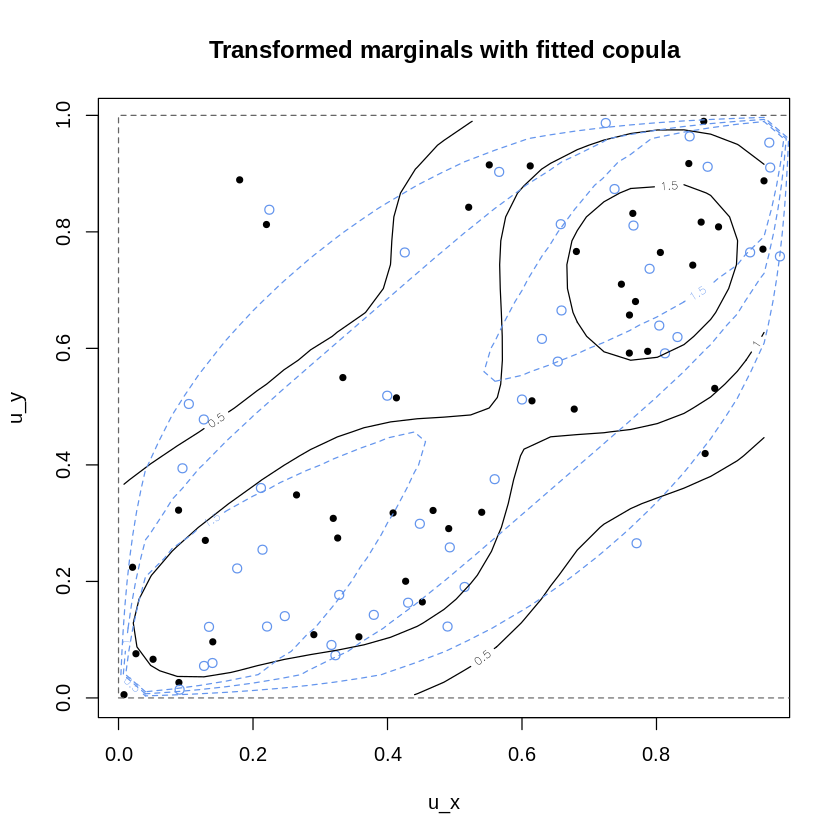

In [7]:
plot_fitted_copula(jmodel, main = "Transformed marginals with fitted copula")

## Plot factual & counterfactual joint return periods

_If the chosen copula fits the data well, we can use it to identify pairs of P and PET with the same joint return period under any specified climate - that is, combinations that are equally (un)likely to occur. These are plotted as joint return period contours._

_We can also add points to indicate the return level of events of interest in the factual and counterfactual climates, to visualise which of the two marginal variables changes most._

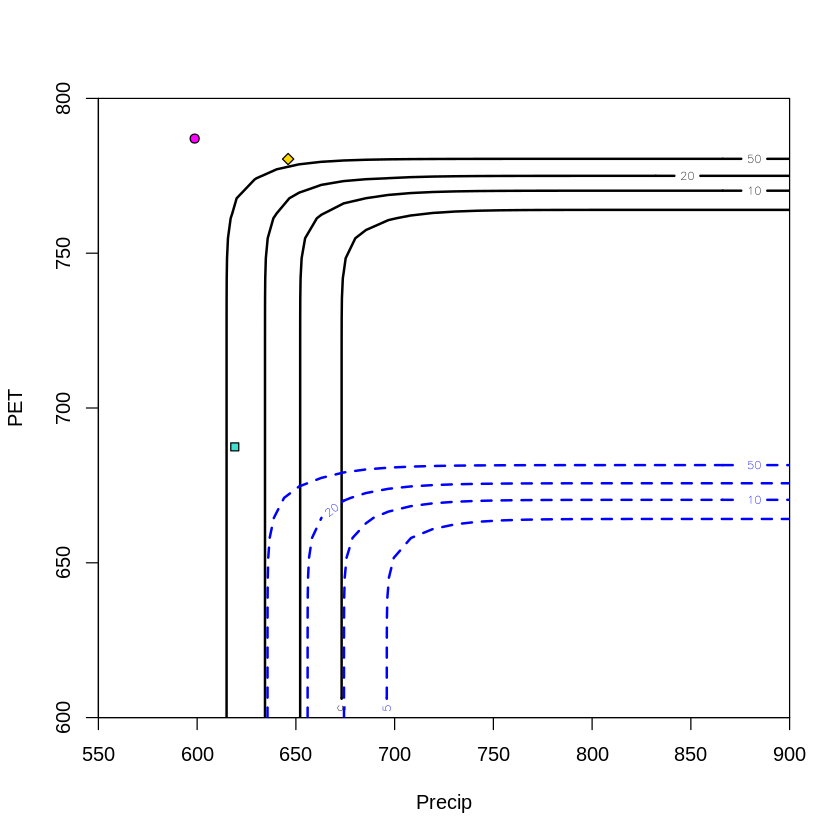

In [5]:
# plot the fitted contours
plot_joint_contour(jmodel, cov_2023, lwd = 2, xlab = "Precip", ylab = "PET", ylim = c(600,800))
plot_joint_contour(jmodel, cov_cf["histnino",,drop = F], lwd = 2, col = "blue", lty = 2, add = T)

# add points to represent the event of interest in the factual & counterfactual climates
plot_joint_event(jmodel, cov_2023, pch = 21, bg = "magenta")
plot_joint_event(jmodel, cov_cf["histnino",,drop = F], pch = 22, bg = "turquoise")
plot_joint_event(jmodel, cov_cf["2023neut",,drop = F], pch = 23, bg = "gold")

## Comparing marginal and joint return periods

_We may also want to evaluate how unusual it was for both of the marginal variables to reach such extreme values simultaneously._

In [13]:
# how unusual are the two marginal variables?
return_period(mdl_pet)[mdl_pet$ev_idx]
return_period(mdl_pr)[mdl_pr$ev_idx]

[1] 177.96

[1] 122.8076

_Both the PET and the precipitation were quite extreme in the 2023 climate (both with return periods of greater than 100 years); we can also see how unusual it was, according to this model, for both to be so extreme simultaneously_

In [14]:
# how unusual is this particular combination of precip and PET in the current climate?
joint_returnperiod(jmodel, fixed_cov = cov_2023)

# how unusual is this combination of precip and PET in various counterfactual climates?
joint_returnperiod(jmodel, fixed_cov = cov_cf)

# the event is so extreme it's impossible to accurately estimate the joint RP in a 1.2C cooler climate

45 
462.4431

histnino      2023neut      histneut 
-4.793054e+16  5.475559e+03  2.809197e+17